In [10]:
# ==================================================
# LEAGUE WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score
)
from sklearn.impute import SimpleImputer

# SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True

# XGBoost (optional)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed. Skipping XGBoost model.")

# Configuration
os.chdir('d:\\ScoreSight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/league_winner')
DATASETS_DIR = Path('datasets')
RAW_LEAGUE_DATA_PATH = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'
FINAL_DATA_PATH = Path('data/league_winner/league_winner_data.csv')
REPORTS_DIR = Path('reports/league_winner')

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

print("="*80)
print("LEAGUE WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SMOTE Available: {IMB_AVAILABLE}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print("="*80)

LEAGUE WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-19 02:34:57
SMOTE Available: True
XGBoost Available: True


In [11]:
# Cell 2: Data Loading and Quality Assessment
# ==================================================

def load_and_assess_data(file_path):
    """
    Load data and perform comprehensive quality assessment
    
    Parameters:
    -----------
    file_path : Path
        Path to the CSV file
        
    Returns:
    --------
    df : DataFrame
        Loaded and initially cleaned dataframe
    quality_report : dict
        Data quality metrics
    """
    print("\n" + "="*80)
    print("DATA LOADING AND QUALITY ASSESSMENT")
    print("="*80)
    
    # Load data
    print(f"\n📂 Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    initial_shape = df.shape
    print(f"✓ Initial shape: {initial_shape}")
    
    # Remove duplicates
    duplicates = df.duplicated().sum()
    df.drop_duplicates(inplace=True)
    print(f"✓ Removed {duplicates} duplicate rows")
    print(f"✓ Final shape: {df.shape}")
    
    # Quality assessment
    quality_report = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'initial_rows': initial_shape[0],
        'initial_columns': initial_shape[1],
        'duplicates_removed': duplicates,
        'final_rows': df.shape[0],
        'final_columns': df.shape[1],
        'missing_values': df.isnull().sum().to_dict(),
        'data_types': df.dtypes.astype(str).to_dict()
    }
    
    # Missing values summary
    missing_summary = df.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0].sort_values(ascending=False)
    
    if len(missing_cols) > 0:
        print(f"\n⚠️  Missing Values Detected:")
        print(missing_cols)
    else:
        print("\n✓ No missing values in raw data")
    
    # Data types
    print(f"\n📊 Data Types:")
    print(df.dtypes.value_counts())
    
    return df, quality_report

# Load data
df_league_raw, quality_report = load_and_assess_data(RAW_LEAGUE_DATA_PATH)


DATA LOADING AND QUALITY ASSESSMENT

📂 Loading data from: datasets\ScoreSight_ML_Season_LeagueWinner_Champion.csv
✓ Initial shape: (180, 16)
✓ Removed 0 duplicate rows
✓ Final shape: (180, 16)

✓ No missing values in raw data

📊 Data Types:
int64      10
float64     4
object      2
Name: count, dtype: int64


In [12]:
# Cell 3: Feature Engineering and Selection
# ==================================================

def engineer_features(df):
    """
    Engineer features and prepare data for modeling
    
    Parameters:
    -----------
    df : DataFrame
        Raw dataframe
        
    Returns:
    --------
    df_model : DataFrame
        Prepared dataframe with selected features
    feature_info : dict
        Information about features
    """
    print("\n" + "="*80)
    print("FEATURE ENGINEERING AND SELECTION")
    print("="*80)
    
    # Define target and columns to exclude
    TARGET_COL = 'target_champion'
    
    # Columns that would cause data leakage
    LEAKAGE_COLS = [
        'points_per_game',  # Direct outcome
        'target_total_points',  # Direct outcome
        'target_league_position',  # Direct outcome
        'goal_difference',  # Calculated from final results
        'wins', 'draws', 'losses',  # Final outcomes
        'points'  # Final outcome
    ]
    
    # Non-feature columns
    META_COLS = [
        'team',
        'season_encoded',
        'team_encoded'
    ]
    
    EXCLUDE_COLS = [TARGET_COL] + LEAKAGE_COLS + META_COLS
    
    print(f"\n🎯 Target Column: {TARGET_COL}")
    print(f"\n🚫 Excluded Columns ({len(EXCLUDE_COLS)}):")
    print(f"   - Leakage prevention: {LEAKAGE_COLS}")
    print(f"   - Meta data: {META_COLS}")
    
    # Identify candidate features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    candidate_features = [col for col in numeric_cols if col not in EXCLUDE_COLS]
    
    print(f"\n📋 Candidate Features ({len(candidate_features)}):")
    for i, feat in enumerate(candidate_features, 1):
        print(f"   {i}. {feat}")
    
    # Check for missing values in features and target
    feature_data = df[candidate_features + [TARGET_COL]]
    missing_before = feature_data.isnull().sum().sum()
    
    if missing_before > 0:
        print(f"\n⚠️  Total missing values in features + target: {missing_before}")
        missing_by_col = feature_data.isnull().sum()
        print(missing_by_col[missing_by_col > 0].sort_values(ascending=False))
    
    # Feature Selection using SelectKBest
    print(f"\n🔍 Performing Feature Selection...")
    
    # Remove rows with missing target or features
    df_clean = feature_data.dropna()
    rows_removed = len(feature_data) - len(df_clean)
    
    if rows_removed > 0:
        print(f"   Removed {rows_removed} rows with missing values")
    
    X_temp = df_clean[candidate_features]
    y_temp = df_clean[TARGET_COL]
    
    # Check class distribution
    print(f"\n📊 Class Distribution:")
    class_dist = y_temp.value_counts()
    print(class_dist)
    print(f"   Champion Rate: {(class_dist.get(1, 0) / len(y_temp) * 100):.2f}%")
    
    # Select top K features
    K = min(7, len(candidate_features))
    selector = SelectKBest(f_classif, k=K)
    selector.fit(X_temp, y_temp)
    
    selected_features = [candidate_features[i] for i in selector.get_support(indices=True)]
    feature_scores = selector.scores_[selector.get_support()]
    
    print(f"\n✓ Selected Top {K} Features (by F-statistic):")
    for feat, score in sorted(zip(selected_features, feature_scores), 
                             key=lambda x: x[1], reverse=True):
        print(f"   - {feat}: {score:.2f}")
    
    # Create final modeling dataset
    df_model = df_clean[selected_features + [TARGET_COL]].copy()
    
    # Feature statistics
    print(f"\n📈 Feature Statistics:")
    feature_stats = df_model[selected_features].describe().T[['mean', 'std', 'min', 'max']]
    print(feature_stats)
    
    feature_info = {
        'target': TARGET_COL,
        'selected_features': selected_features,
        'feature_scores': dict(zip(selected_features, feature_scores.tolist())),
        'excluded_columns': EXCLUDE_COLS,
        'leakage_prevented': LEAKAGE_COLS,
        'rows_after_cleaning': len(df_model),
        'class_distribution': class_dist.to_dict()
    }
    
    return df_model, feature_info

# Engineer features
df_model, feature_info = engineer_features(df_league_raw)

# Save feature info
with open(REPORTS_DIR / 'feature_engineering_report.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"\n💾 Feature engineering report saved to: {REPORTS_DIR / 'feature_engineering_report.json'}")


FEATURE ENGINEERING AND SELECTION

🎯 Target Column: target_champion

🚫 Excluded Columns (12):
   - Leakage prevention: ['points_per_game', 'target_total_points', 'target_league_position', 'goal_difference', 'wins', 'draws', 'losses', 'points']
   - Meta data: ['team', 'season_encoded', 'team_encoded']

📋 Candidate Features (6):
   1. matches_played
   2. goals_scored
   3. goals_conceded
   4. target_top_4
   5. target_top_6
   6. target_relegated

🔍 Performing Feature Selection...

📊 Class Distribution:
target_champion
0    171
1      9
Name: count, dtype: int64
   Champion Rate: 5.00%

✓ Selected Top 6 Features (by F-statistic):
   - matches_played: nan
   - goals_scored: 51.78
   - target_top_4: 45.45
   - goals_conceded: 27.54
   - target_top_6: 24.18
   - target_relegated: 1.67

📈 Feature Statistics:
                       mean        std   min    max
matches_played    38.000000   0.000000  38.0   38.0
goals_scored      53.833333  17.635509  20.0  106.0
goals_conceded    53.83333


EXPLORATORY DATA ANALYSIS

📊 Creating distribution plots...


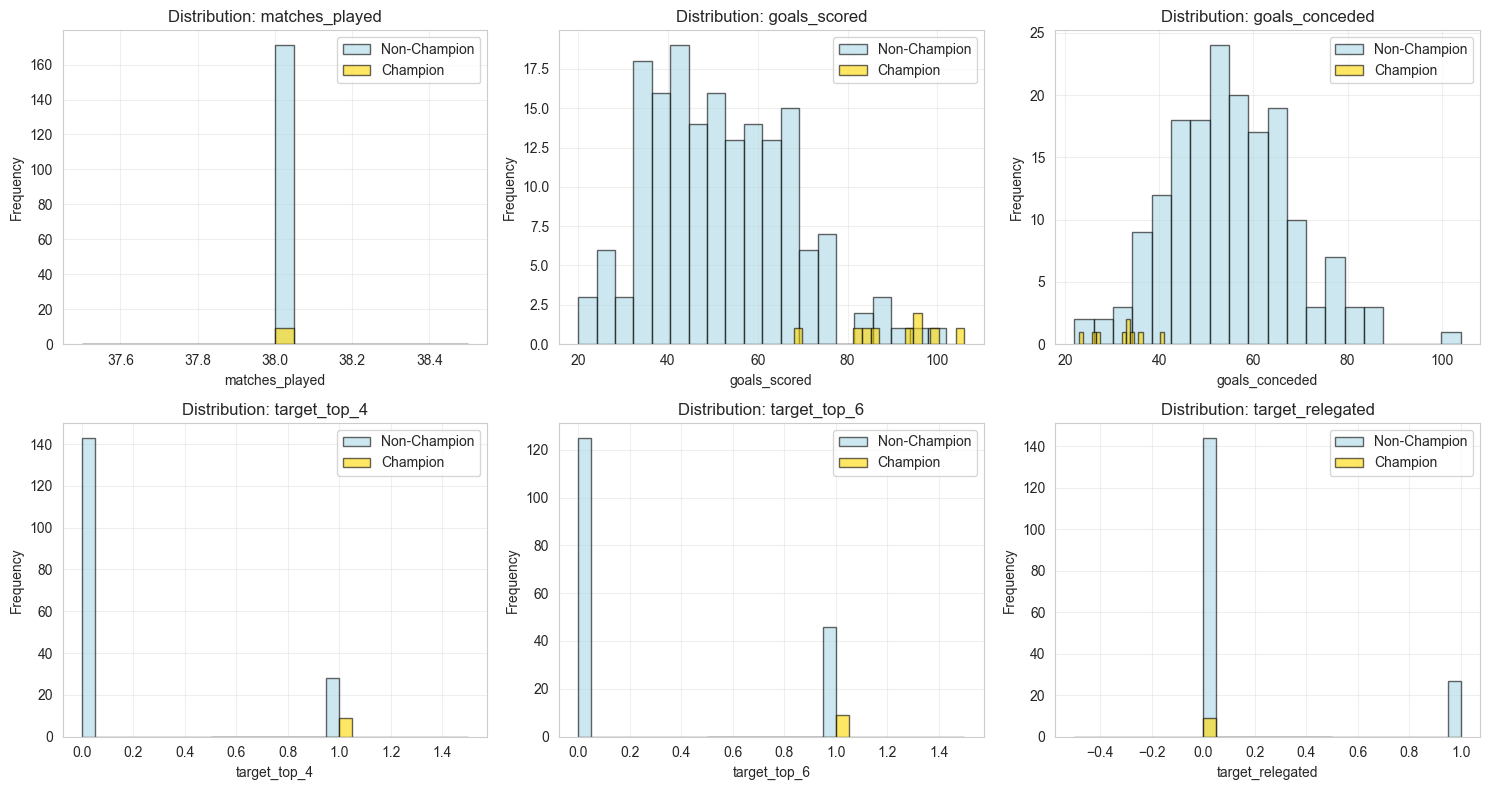

✓ Saved to: visualizations\league_winner\feature_distributions.png

🔥 Creating correlation heatmap...


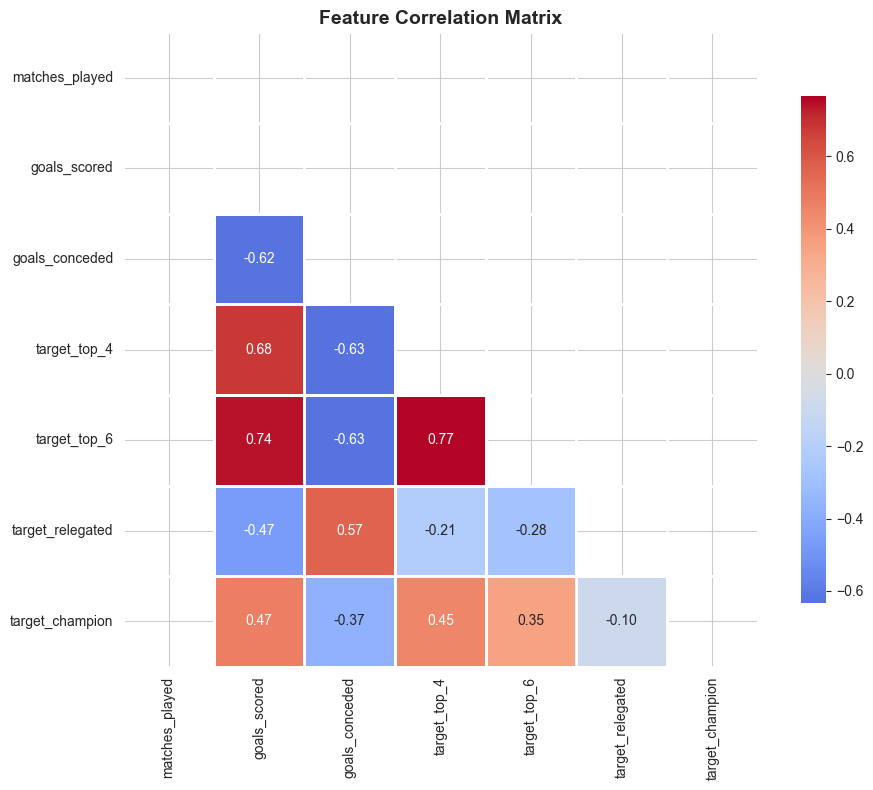

✓ Saved to: visualizations\league_winner\correlation_heatmap.png

📦 Creating box plots...


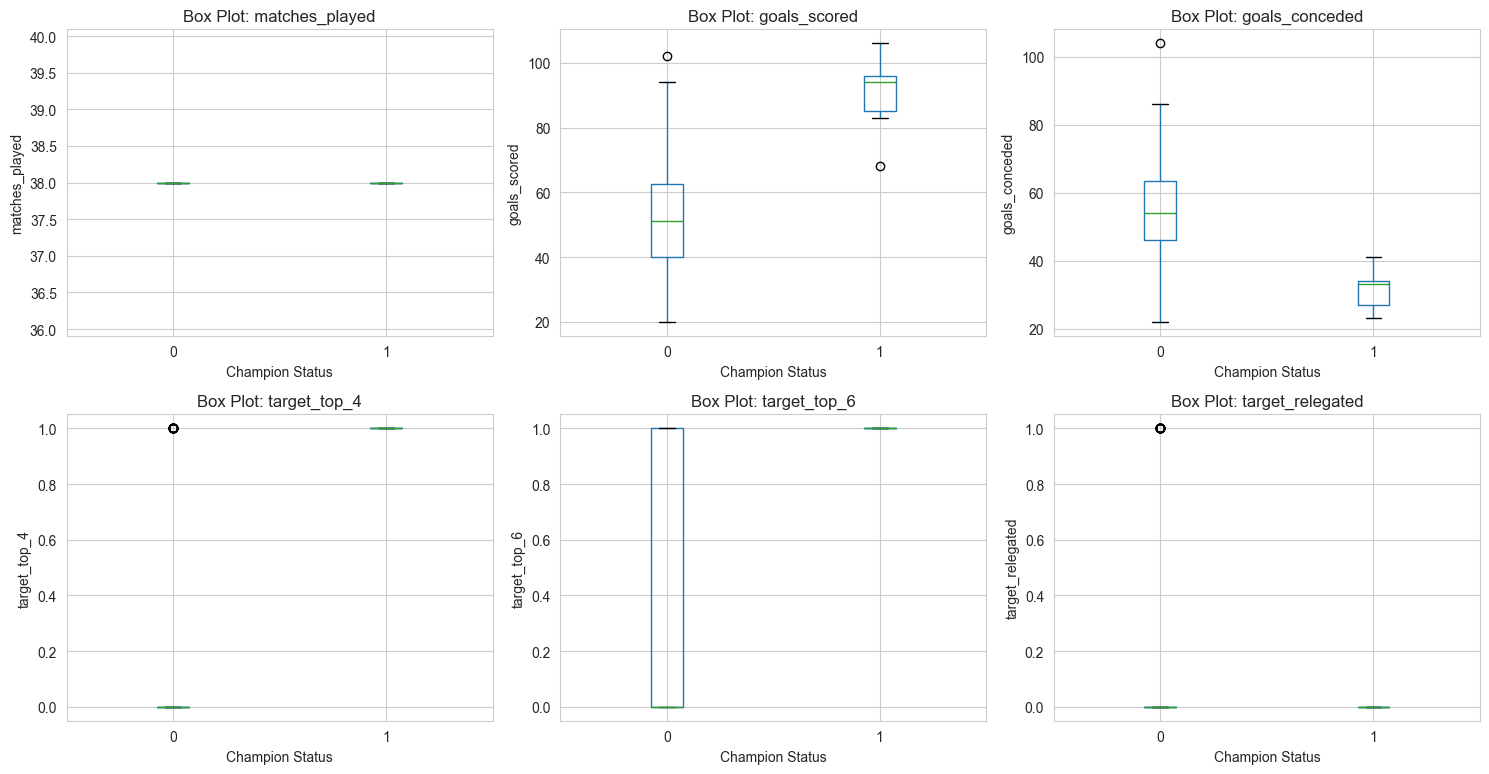

✓ Saved to: visualizations\league_winner\outlier_boxplots.png

⭐ Creating feature importance chart...


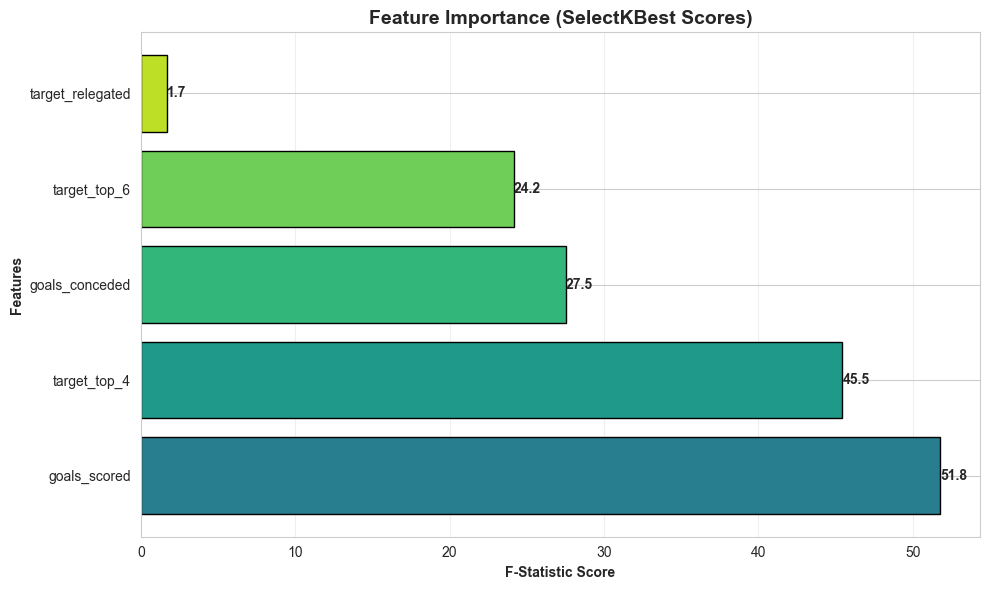

✓ Saved to: visualizations\league_winner\feature_importance_scores.png

💾 Processed data saved to: data\league_winner\league_winner_data.csv


In [13]:
# Cell 4: Exploratory Data Analysis and Visualization
# ==================================================

def create_eda_visualizations(df, feature_info, save_dir):
    """
    Create comprehensive EDA visualizations
    
    Parameters:
    -----------
    df : DataFrame
        Modeling dataframe
    feature_info : dict
        Feature information
    save_dir : Path
        Directory to save visualizations
    """
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    features = feature_info['selected_features']
    target = feature_info['target']
    
    # 1. Distribution plots
    print("\n📊 Creating distribution plots...")
    n_features = len(features)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(features):
        ax = axes[idx]
        
        # Separate by target class
        champions = df[df[target] == 1][feature]
        non_champions = df[df[target] == 0][feature]
        
        ax.hist(non_champions, bins=20, alpha=0.6, label='Non-Champion', color='lightblue', edgecolor='black')
        ax.hist(champions, bins=20, alpha=0.6, label='Champion', color='gold', edgecolor='black')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution: {feature}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    dist_path = save_dir / 'feature_distributions.png'
    plt.savefig(dist_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {dist_path}")
    
    # 2. Correlation heatmap
    print("\n🔥 Creating correlation heatmap...")
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_matrix = df[features + [target]].corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True,
                linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    
    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    corr_path = save_dir / 'correlation_heatmap.png'
    plt.savefig(corr_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {corr_path}")
    
    # 3. Box plots for outlier detection
    print("\n📦 Creating box plots...")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(features):
        ax = axes[idx]
        df.boxplot(column=feature, by=target, ax=ax)
        ax.set_xlabel('Champion Status')
        ax.set_ylabel(feature)
        ax.set_title(f'Box Plot: {feature}')
        ax.get_figure().suptitle('')
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    box_path = save_dir / 'outlier_boxplots.png'
    plt.savefig(box_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {box_path}")
    
    # 4. Feature importance from scores
    print("\n⭐ Creating feature importance chart...")
    feature_scores = feature_info['feature_scores']
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    features_sorted = [f[0] for f in sorted_features]
    scores_sorted = [f[1] for f in sorted_features]
    
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features_sorted)))
    bars = ax.barh(features_sorted, scores_sorted, color=colors, edgecolor='black')
    
    ax.set_xlabel('F-Statistic Score', fontweight='bold')
    ax.set_ylabel('Features', fontweight='bold')
    ax.set_title('Feature Importance (SelectKBest Scores)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    imp_path = save_dir / 'feature_importance_scores.png'
    plt.savefig(imp_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {imp_path}")

# Create visualizations
create_eda_visualizations(df_model, feature_info, VIZ_DIR)

# Save processed data
df_model.to_csv(FINAL_DATA_PATH, index=False)
print(f"\n💾 Processed data saved to: {FINAL_DATA_PATH}")

In [14]:
# Cell 5: Model Training and Evaluation
# ==================================================

def train_and_evaluate_models(df, feature_info, random_state=42):
    """
    Train multiple models and evaluate performance
    
    Parameters:
    -----------
    df : DataFrame
        Modeling dataframe
    feature_info : dict
        Feature information
    random_state : int
        Random seed
        
    Returns:
    --------
    results : dict
        Training results and best model
    """
    print("\n" + "="*80)
    print("MODEL TRAINING AND EVALUATION")
    print("="*80)
    
    # Prepare data
    TARGET_COL = feature_info['target']
    features = feature_info['selected_features']
    
    X = df[features]
    y = df[TARGET_COL].astype(int)
    
    print(f"\n📊 Dataset Info:")
    print(f"   Features: {len(features)}")
    print(f"   Samples: {len(X)}")
    print(f"   Champion samples: {y.sum()}")
    print(f"   Non-champion samples: {len(y) - y.sum()}")
    print(f"   Class imbalance ratio: 1:{(len(y) - y.sum()) / y.sum():.1f}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state, stratify=y
    )
    
    print(f"\n✂️  Train-Test Split:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Testing: {len(X_test)} samples")
    
    # Define models
    models = {
        'RandomForest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
    }
    
    if XGB_AVAILABLE:
        models['XGBoost'] = xgb.XGBClassifier(
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        )
    
    # Hyperparameter grids
    param_grids = {
        'RandomForest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10]
        },
        'GradientBoosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7]
        }
    }
    
    # Training results
    training_results = []
    trained_models = {}
    
    # Train each model
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Training: {model_name}")
        print(f"{'='*60}")
        
        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=random_state)),
            ('model', model)
        ])
        
        # Hyperparameter search
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grids[model_name],
            n_iter=20,
            cv=StratifiedKFold(5, shuffle=True, random_state=random_state),
            scoring='f1_macro',
            n_jobs=-1,
            random_state=random_state,
            verbose=0
        )
        
        # Fit model
        search.fit(X_train, y_train)
        
        # Predictions
        y_pred = search.predict(X_test)
        y_proba = search.predict_proba(X_test)[:, 1] if hasattr(search, 'predict_proba') else None
        
        # Metrics
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        
        results_dict = {
            'Model': model_name,
            'Best_CV_F1': search.best_score_,
            'Test_F1_Macro': f1_macro,
            'Test_F1_Weighted': f1_weighted,
            'Test_Accuracy': accuracy,
            'Test_Precision': precision,
            'Test_Recall': recall,
            'Test_ROC_AUC': roc_auc
        }
        
        training_results.append(results_dict)
        trained_models[model_name] = {
            'pipeline': search.best_estimator_,
            'search': search,
            'predictions': y_pred,
            'probabilities': y_proba,
            'metrics': results_dict
        }
        
        print(f"✓ Best CV F1: {search.best_score_:.4f}")
        print(f"✓ Test F1 (Macro): {f1_macro:.4f}")
        print(f"✓ Test Accuracy: {accuracy:.4f}")
        print(f"✓ Test ROC-AUC: {roc_auc:.4f}")
    
    # Summary table
    summary_df = pd.DataFrame(training_results).sort_values(
        'Test_F1_Macro', ascending=False
    )
    
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    display(summary_df.style.format({
        'Best_CV_F1': '{:.4f}',
        'Test_F1_Macro': '{:.4f}',
        'Test_F1_Weighted': '{:.4f}',
        'Test_Accuracy': '{:.4f}',
        'Test_Precision': '{:.4f}',
        'Test_Recall': '{:.4f}',
        'Test_ROC_AUC': '{:.4f}'
    }).background_gradient(subset=['Test_F1_Macro'], cmap='YlGn'))
    
    # Best model
    best_model_name = summary_df.iloc[0]['Model']
    best_model_data = trained_models[best_model_name]
    
    print(f"\n🏆 Best Model: {best_model_name}")
    
    return {
        'summary': summary_df,
        'trained_models': trained_models,
        'best_model_name': best_model_name,
        'best_model': best_model_data,
        'X_test': X_test,
        'y_test': y_test
    }

# Train models
training_results = train_and_evaluate_models(df_model, feature_info, RANDOM_STATE)


MODEL TRAINING AND EVALUATION

📊 Dataset Info:
   Features: 6
   Samples: 180
   Champion samples: 9
   Non-champion samples: 171
   Class imbalance ratio: 1:19.0

✂️  Train-Test Split:
   Training: 135 samples
   Testing: 45 samples

Training: RandomForest
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9767

Training: GradientBoosting
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9767

Training: GradientBoosting
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9884

Training: XGBoost
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9884

Training: XGBoost
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9826

MODEL COMPARISON SUMMARY
✓ Best CV F1: nan
✓ Test F1 (Macro): 0.8941
✓ Test Accuracy: 0.9778
✓ Test ROC-AUC: 0.9826

MODEL COMPARISON SUMMARY


,Model,Best_CV_F1,Test_F1_Macro,Test_F1_Weighted,Test_Accuracy,Test_Precision,Test_Recall,Test_ROC_AUC
0,RandomForest,nan,0.8941,0.9799,0.9778,0.8333,0.9884,0.9767
1,GradientBoosting,nan,0.8941,0.9799,0.9778,0.8333,0.9884,0.9884
2,XGBoost,nan,0.8941,0.9799,0.9778,0.8333,0.9884,0.9826



🏆 Best Model: RandomForest



BEST MODEL ANALYSIS

🏆 Model: RandomForest

📊 Classification Report:
              precision    recall  f1-score   support

Non-Champion     1.0000    0.9767    0.9882        43
    Champion     0.6667    1.0000    0.8000         2

    accuracy                         0.9778        45
   macro avg     0.8333    0.9884    0.8941        45
weighted avg     0.9852    0.9778    0.9799        45


📈 Confusion Matrix:


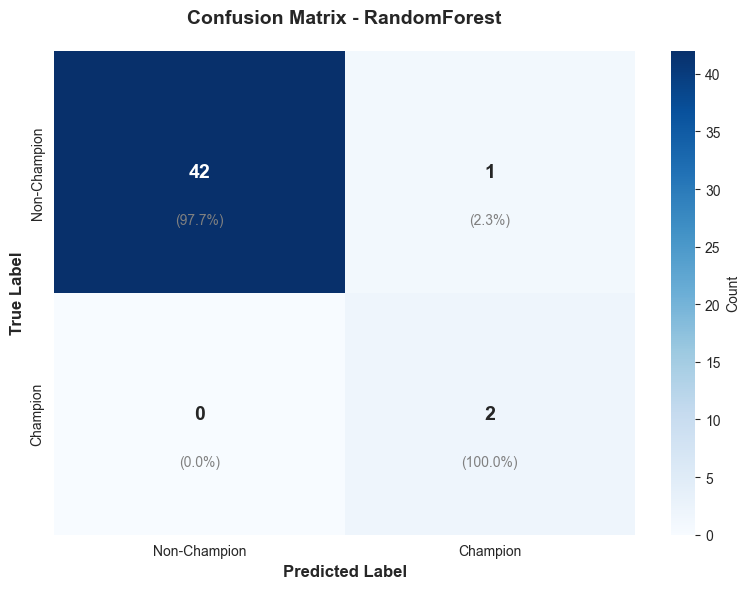

✓ Saved to: visualizations\league_winner\confusion_matrix_RandomForest.png

📉 ROC Curve:


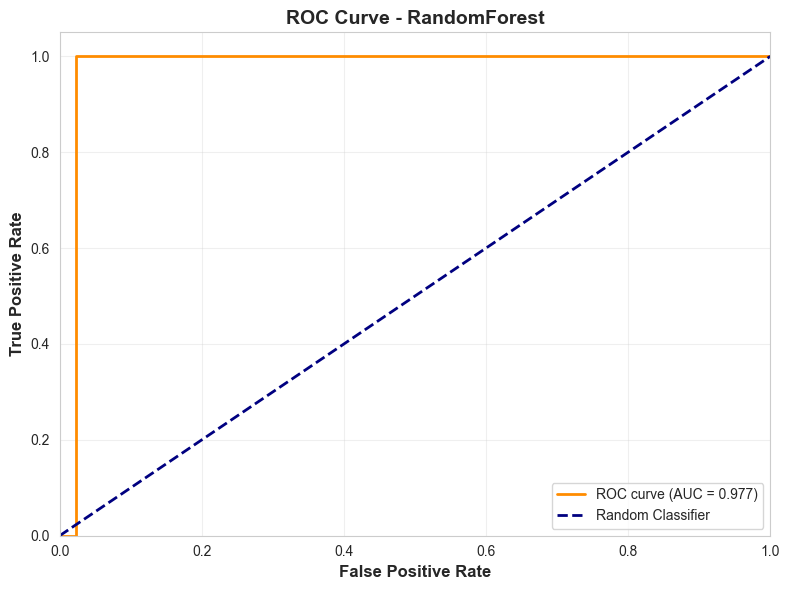

✓ Saved to: visualizations\league_winner\roc_curve_RandomForest.png

⭐ Feature Importance:
   1. goals_scored: 0.4162
   2. goals_conceded: 0.3216
   3. target_top_4: 0.1541
   4. target_top_6: 0.1019
   5. target_relegated: 0.0063
   6. matches_played: 0.0000


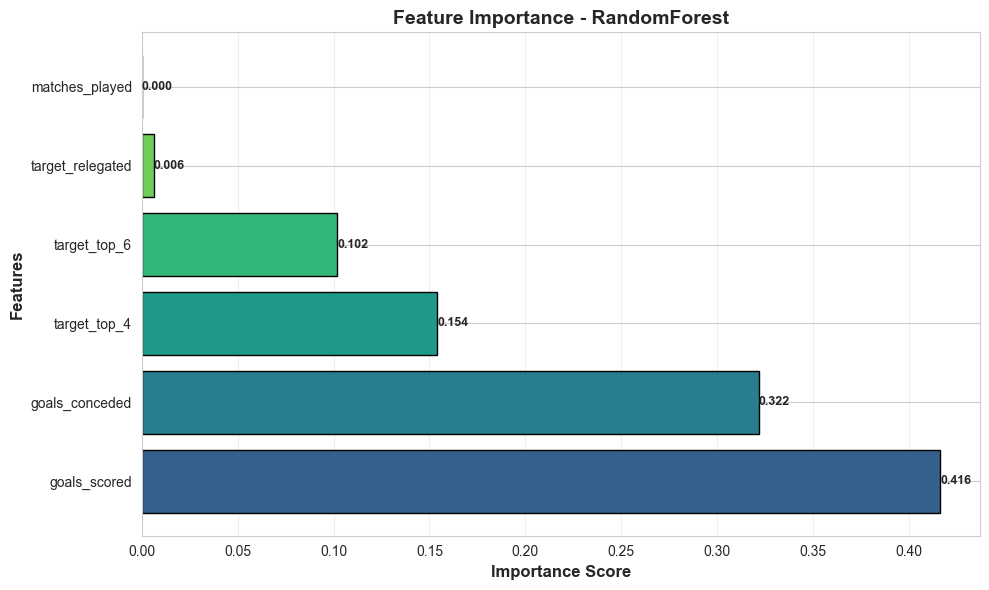

✓ Saved to: visualizations\league_winner\feature_importance_RandomForest.png

📊 Prediction Probability Distribution:


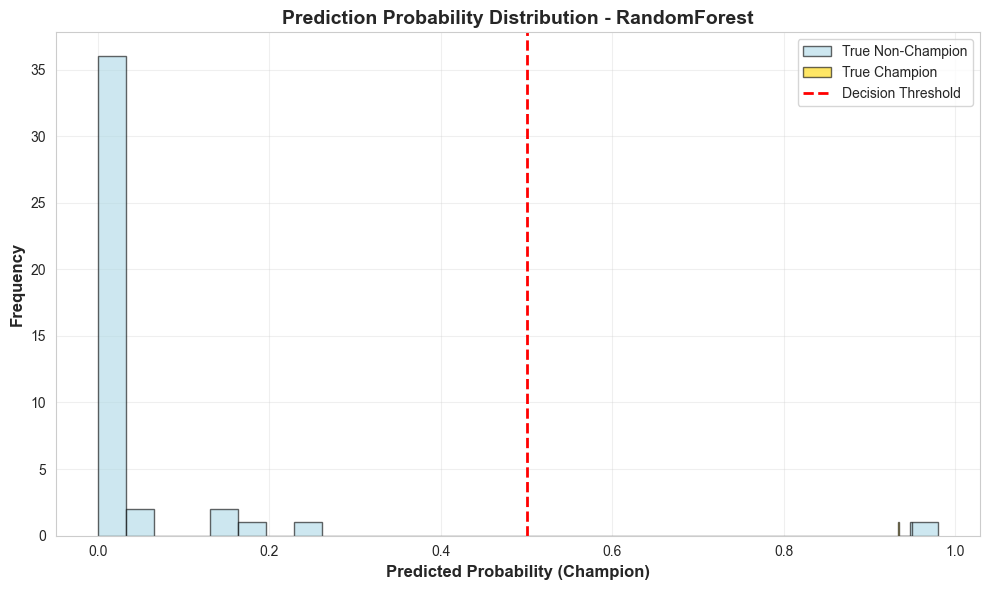

✓ Saved to: visualizations\league_winner\probability_distribution_RandomForest.png

📊 Creating Model Comparison Chart:


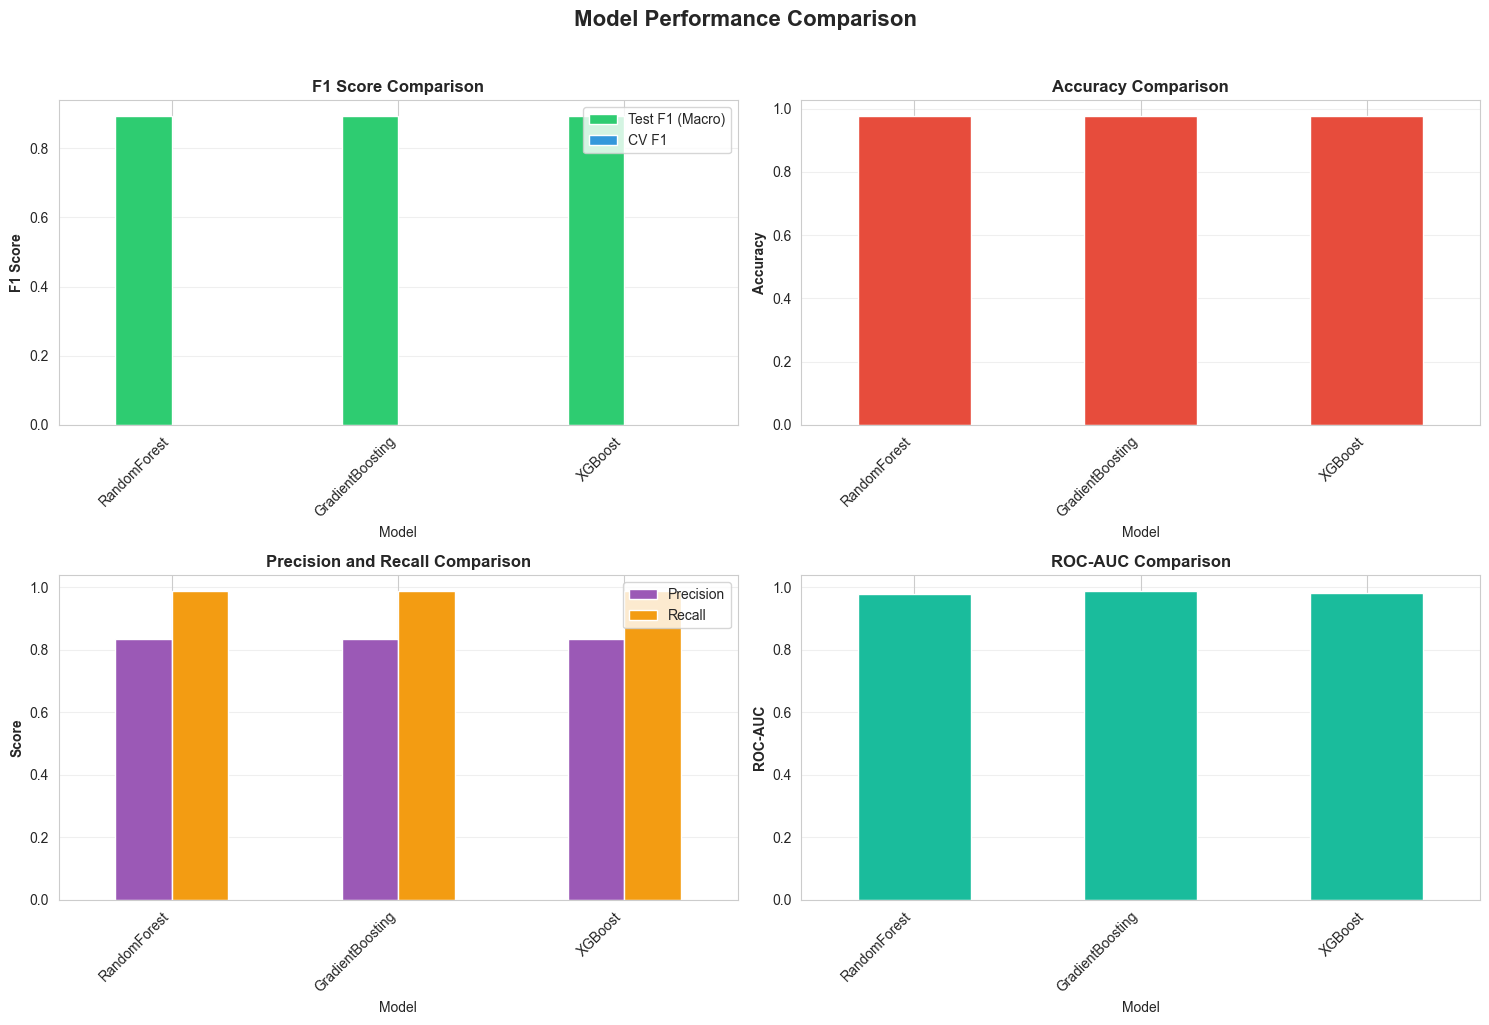

✓ Saved to: visualizations\league_winner\model_comparison_dashboard.png


In [15]:
# Cell 6: Detailed Model Analysis and Visualization
# ==================================================

def analyze_best_model(results, feature_info, save_dir):
    """
    Perform detailed analysis of the best model
    
    Parameters:
    -----------
    results : dict
        Training results
    feature_info : dict
        Feature information
    save_dir : Path
        Directory to save visualizations
    """
    print("\n" + "="*80)
    print("BEST MODEL ANALYSIS")
    print("="*80)
    
    best_model_name = results['best_model_name']
    best_model_data = results['best_model']
    y_test = results['y_test']
    y_pred = best_model_data['predictions']
    y_proba = best_model_data['probabilities']
    
    print(f"\n🏆 Model: {best_model_name}")
    
    # 1. Classification Report
    print(f"\n📊 Classification Report:")
    print("="*60)
    report = classification_report(
        y_test, y_pred,
        target_names=['Non-Champion', 'Champion'],
        digits=4
    )
    print(report)
    
    # 2. Confusion Matrix
    print(f"\n📈 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Champion', 'Champion'],
                yticklabels=['Non-Champion', 'Champion'],
                cbar_kws={'label': 'Count'}, ax=ax,
                annot_kws={'size': 14, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
    ax.set_title(f'Confusion Matrix - {best_model_name}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add percentage annotations
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                          ha="center", va="center", color="gray", fontsize=10)
    
    plt.tight_layout()
    cm_path = save_dir / f'confusion_matrix_{best_model_name}.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {cm_path}")
    
    # 3. ROC Curve
    if y_proba is not None:
        print(f"\n📉 ROC Curve:")
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
        ax.set_title(f'ROC Curve - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        ax.legend(loc="lower right", fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        roc_path = save_dir / f'roc_curve_{best_model_name}.png'
        plt.savefig(roc_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved to: {roc_path}")
    
    # 4. Feature Importance
    pipeline = best_model_data['pipeline']
    model = pipeline.named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        print(f"\n⭐ Feature Importance:")
        
        importances = model.feature_importances_
        features = feature_info['selected_features']
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        sorted_features = [features[i] for i in indices]
        sorted_importances = importances[indices]
        
        # Print
        for i, (feat, imp) in enumerate(zip(sorted_features, sorted_importances), 1):
            print(f"   {i}. {feat}: {imp:.4f}")
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_features)))
        bars = ax.barh(sorted_features, sorted_importances, color=colors, edgecolor='black')
        
        ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
        ax.set_ylabel('Features', fontweight='bold', fontsize=12)
        ax.set_title(f'Feature Importance - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', 
                    fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        fi_path = save_dir / f'feature_importance_{best_model_name}.png'
        plt.savefig(fi_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved to: {fi_path}")
    
    # 5. Prediction Probability Distribution
    if y_proba is not None:
        print(f"\n📊 Prediction Probability Distribution:")
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Separate probabilities by true class
        proba_0 = y_proba[y_test == 0]
        proba_1 = y_proba[y_test == 1]
        
        ax.hist(proba_0, bins=30, alpha=0.6, label='True Non-Champion', 
                color='lightblue', edgecolor='black')
        ax.hist(proba_1, bins=30, alpha=0.6, label='True Champion', 
                color='gold', edgecolor='black')
        
        ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, 
                   label='Decision Threshold')
        
        ax.set_xlabel('Predicted Probability (Champion)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
        ax.set_title(f'Prediction Probability Distribution - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        prob_path = save_dir / f'probability_distribution_{best_model_name}.png'
        plt.savefig(prob_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved to: {prob_path}")
    
    # 6. Model Comparison Chart
    print(f"\n📊 Creating Model Comparison Chart:")
    summary = results['summary']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # F1 Score comparison
    ax = axes[0, 0]
    summary.plot(x='Model', y=['Test_F1_Macro', 'Best_CV_F1'], 
                 kind='bar', ax=ax, color=['#2ecc71', '#3498db'])
    ax.set_ylabel('F1 Score', fontweight='bold')
    ax.set_title('F1 Score Comparison', fontweight='bold')
    ax.legend(['Test F1 (Macro)', 'CV F1'])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # Accuracy comparison
    ax = axes[0, 1]
    summary.plot(x='Model', y='Test_Accuracy', kind='bar', ax=ax, 
                 color='#e74c3c', legend=False)
    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_title('Accuracy Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # Precision and Recall
    ax = axes[1, 0]
    summary.plot(x='Model', y=['Test_Precision', 'Test_Recall'], 
                 kind='bar', ax=ax, color=['#9b59b6', '#f39c12'])
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Precision and Recall Comparison', fontweight='bold')
    ax.legend(['Precision', 'Recall'])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # ROC-AUC
    ax = axes[1, 1]
    summary.plot(x='Model', y='Test_ROC_AUC', kind='bar', ax=ax, 
                 color='#1abc9c', legend=False)
    ax.set_ylabel('ROC-AUC', fontweight='bold')
    ax.set_title('ROC-AUC Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    comp_path = save_dir / 'model_comparison_dashboard.png'
    plt.savefig(comp_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {comp_path}")

# Analyze best model
analyze_best_model(training_results, feature_info, VIZ_DIR)

In [16]:
# Cell 7: Save Models and Generate Final Report
# ==================================================

def save_models_and_report(results, feature_info, quality_report):
    """
    Save trained models and generate final report
    
    Parameters:
    -----------
    results : dict
        Training results
    feature_info : dict
        Feature information
    quality_report : dict
        Data quality report
    """
    print("\n" + "="*80)
    print("SAVING MODELS AND GENERATING REPORT")
    print("="*80)
    
    best_model_name = results['best_model_name']
    best_model_data = results['best_model']
    
    # Save best model
    model_path = MODELS_DIR / f'league_winner_best_model_{best_model_name}.joblib'
    joblib.dump(best_model_data['pipeline'], model_path)
    print(f"\n✓ Best model saved to: {model_path}")
    
    # Save all models
    for model_name, model_data in results['trained_models'].items():
        model_path = MODELS_DIR / f'league_winner_{model_name}.joblib'
        joblib.dump(model_data['pipeline'], model_path)
        print(f"✓ {model_name} model saved to: {model_path}")
    
    # Generate comprehensive report
    final_report = {
        'pipeline_info': {
            'name': 'League Winner Prediction',
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'random_state': RANDOM_STATE,
            'test_size': TEST_SIZE
        },
        'data_quality': quality_report,
        'feature_engineering': feature_info,
        'model_performance': {
            'best_model': best_model_name,
            'all_models': results['summary'].to_dict('records')
        },
        'best_model_metrics': best_model_data['metrics']
    }
    
    # Save report
    report_path = REPORTS_DIR / 'final_pipeline_report.json'
    with open(report_path, 'w') as f:
        json.dump(final_report, f, indent=2, default=str)
    
    print(f"\n✓ Final report saved to: {report_path}")
    
    # Create summary text report
    summary_text = f"""
{'='*80}
LEAGUE WINNER PREDICTION - FINAL REPORT
{'='*80}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATA QUALITY
{'='*80}
- Initial Rows: {quality_report['initial_rows']}
- Final Rows: {quality_report['final_rows']}
- Duplicates Removed: {quality_report['duplicates_removed']}
- Features Used: {len(feature_info['selected_features'])}

FEATURES
{'='*80}
Target: {feature_info['target']}

Selected Features:
{chr(10).join(f"  - {feat}" for feat in feature_info['selected_features'])}

Excluded (Leakage Prevention):
{chr(10).join(f"  - {col}" for col in feature_info['leakage_prevented'])}

CLASS DISTRIBUTION
{'='*80}
{chr(10).join(f"  - Class {k}: {v} samples" for k, v in feature_info['class_distribution'].items())}

MODEL PERFORMANCE
{'='*80}
Best Model: {best_model_name}

Metrics:
  - Test F1 (Macro): {best_model_data['metrics']['Test_F1_Macro']:.4f}
  - Test Accuracy: {best_model_data['metrics']['Test_Accuracy']:.4f}
  - Test Precision: {best_model_data['metrics']['Test_Precision']:.4f}
  - Test Recall: {best_model_data['metrics']['Test_Recall']:.4f}
  - Test ROC-AUC: {best_model_data['metrics']['Test_ROC_AUC']:.4f}

ALL MODELS COMPARISON
{'='*80}
{results['summary'].to_string()}

{'='*80}
END OF REPORT
{'='*80}
    """
    
    summary_path = REPORTS_DIR / 'pipeline_summary.txt'
    with open(summary_path, 'w') as f:
        f.write(summary_text)
    
    print(f"✓ Summary report saved to: {summary_path}")
    
    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nOutput Locations:")
    print(f"  📊 Visualizations: {VIZ_DIR}")
    print(f"  🤖 Models: {MODELS_DIR}")
    print(f"  📄 Reports: {REPORTS_DIR}")
    print(f"  💾 Processed Data: {FINAL_DATA_PATH}")

# Save everything
save_models_and_report(training_results, feature_info, quality_report)


SAVING MODELS AND GENERATING REPORT

✓ Best model saved to: models\league_winner_best_model_RandomForest.joblib
✓ RandomForest model saved to: models\league_winner_RandomForest.joblib
✓ GradientBoosting model saved to: models\league_winner_GradientBoosting.joblib
✓ XGBoost model saved to: models\league_winner_XGBoost.joblib

✓ Final report saved to: reports\league_winner\final_pipeline_report.json
✓ Summary report saved to: reports\league_winner\pipeline_summary.txt

✅ PIPELINE COMPLETED SUCCESSFULLY!

Output Locations:
  📊 Visualizations: visualizations\league_winner
  🤖 Models: models
  📄 Reports: reports\league_winner
  💾 Processed Data: data\league_winner\league_winner_data.csv
